# Plotting results of predictions




In [39]:
import folium
import odc.geo
import numpy as np
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
from odc.algo import xr_reproject
from datacube.utils.cog import write_cog
from matplotlib.colors import ListedColormap

import sys
sys.path.append('/g/data/os22/chad_tmp/NEE_modelling/')
from collect_prediction_data import allNaN_arg

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize

import warnings
warnings.filterwarnings("ignore")

## Analysis Parameters

In [40]:
var = 'ER'
suffix='20230109'
results_name = var+'_2003_2021_5km_LGBM_'+suffix+'.nc'
mask_path = '/g/data/os22/chad_tmp/NEE_modelling/results/prediction_data/mask_5km.nc'

upper = var+'_2003_2021_5km_LGBM_quantiles_'+suffix+'.nc'

### Open predictions

In [41]:
ds = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+results_name)
ds.attrs['nodata'] = np.nan

ds_upper = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/'+upper)

### Optionally calculate NEE as a residual

Really GPP should be the residual since NEE is the variable directly measured by the EC tower, ER is measured at night and extrapolated, and GPP is the residual.

In [42]:
# gpp = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/GPP_2003_2021_5km_LGBM_'+suffix+'.nc')
# gpp.attrs['nodata'] = np.nan

# er = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/results/predictions/ER_2003_2021_5km_LGBM_'+suffix+'.nc')
# er.attrs['nodata'] = np.nan

# ds = gpp - er
# ds = ds*-1
# ds = ds.rename('NEE')

## Convert to PgC/year

In [43]:
grid = ds.odc.geobox.to_crs('EPSG:3577')

In [44]:
ds = xr_reproject(ds, geobox=grid.compat, resampling='bilinear')
ds_upper = xr_reproject(ds_upper, geobox=grid.compat, resampling='bilinear')

In [45]:
area_per_pixel = ds.geobox.resolution[1]**2

ds = ds * area_per_pixel * 1e-15 * 12

ds_upper = ds_upper * area_per_pixel * 1e-15 *12


## Fire emissions

In [46]:
fire = xr.open_dataarray('/g/data/os22/chad_tmp/NEE_modelling/data/FireEmissions_10km_monthly_2003_2021.nc')
fire = fire.sum(['x', 'y'])
fire = fire*12

## Zonal timeseries

Add uncertainty envelopes, add median of ensembles as a dashed line

In [47]:
ds_1D = ds.sum(['x','y'])
ds_fire_1d = ds_1D+fire

ds_upper_1D = ds_upper.sum(['x','y'])
ds_upper_fire_1D = ds_upper_1D+fire

In [48]:
print('w/o fire:', ds_1D.mean().values, ds_1D.std().values)
print('w fire:', ds_fire_1d.mean().values, ds_fire_1d.std().values)

w/o fire: 2.8885133 1.1221192
w fire: 3.0377505 1.1039615


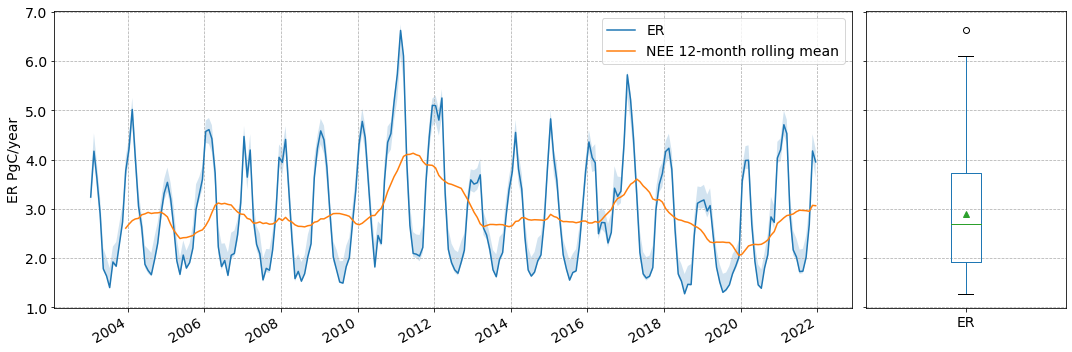

In [49]:
df_1d = ds_1D.drop('spatial_ref').to_dataframe()
if var == 'NEE':
    df_1d['NEE+fire'] = ds_fire_1d.drop('spatial_ref').to_dataframe(name='NEE+fire')

fig,ax = plt.subplots(1,2, figsize=(15,5), sharey=True, gridspec_kw={'width_ratios': [4, 1]})
ds_1D.plot(linestyle='-', ax=ax[0], label=var)
ds_1D.rolling(time=12, min_periods=12).mean().plot(ax=ax[0], label='NEE 12-month rolling mean')
ax[0].fill_between(ds_1D.time, ds_upper_1D.sel(quantile=0.25),
                ds_upper_1D.sel(quantile=0.75), alpha=0.2)
df_1d.boxplot(ax=ax[1], rot=0, grid=False, fontsize=14, showmeans=True)
if var == 'NEE':
    ds_fire_1d.plot(linestyle='--', ax=ax[0], label='NEE+Fire', c='purple', alpha=0.5)
    ds_fire_1d.rolling(time=12, min_periods=12).mean().plot(ax=ax[0], label='NEE+fire 12-month rolling mean')
    # ax.text(.015, .95, f'Mean: {ds_fire_1d.mean().values:.3f}, std: {ds_fire_1d.std().values:.3f} PgC/yr',
    #     transform=ax.transAxes)
    ax[0].axhline(0, c='grey', linestyle='--')
    ax[1].axhline(0, c='grey', linestyle='--')
    # ax.legend(loc='lower right')
# ax.text(.015, .90, f'Mean: {ds_1D.mean().values:.3f}, std: {ds_1D.std().values:.3f} PgC/yr',
#         transform=ax.transAxes);
ax[0].set_ylabel(var+' PgC/year', fontsize=14)
ax[0].tick_params(axis='x', labelsize=14)
ax[0].tick_params(axis='y', labelsize=14)
ax[0].set_yticklabels(['{:3.1f}'.format(x) for x in ax[0].get_yticks()])
ax[0].set_xlabel('')
ax[0].set_title('')
ax[0].grid('off', which='major', axis='both', linestyle='--', linewidth=0.75)
ax[1].grid('off', which='major', axis='y', linestyle='--', linewidth=0.75)
ax[0].legend(loc='best', fontsize=14)
plt.tight_layout()
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_aus_timeseries_with_boxplot_'+suffix+'.png')

## Plots per bioregion

In [ ]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/NEE_modelling/data/bioclimatic_regions.geojson')
gdf.head()

In [ ]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    print(row['region_name'])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    dss = ds.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: dss})

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(12,15), sharex=True)

for ax, k in zip(axs.ravel(), results.keys()):
    
    _1D = results[k].sum(['x','y'])
    
    _1D.plot(linestyle='--', ax=ax, label=var, )
    ax.text(.015, .95, f'Mean: {_1D.mean().values:.3f}, std: {_1D.std().values:.3f} PgC/yr',
        transform=ax.transAxes, fontdict={'fontsize': 14})
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    ax.set_title(k, fontdict={'fontsize': 14})
    ax.set_ylabel('')
    ax.set_xlabel('')

fig.supylabel(var+' PgC/year', fontsize=14)
plt.tight_layout()
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion'+suffix+'.png')

## Per-pixel summaries

In [ ]:
annual_mean = ds.resample(time='1Y').sum().mean('time')
annual_std = ds.resample(time='1Y').sum().std('time')
scaled_variance = annual_std / annual_mean

In [ ]:
monthly_mean = ds.groupby('time.month').mean() #.sel(time=slice('2003','2015'))
if var == 'NEE':
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'min')
    # max_mean_season = allNaN_arg(monthly_season, 'season', 'min')
else:
    max_mean_month = allNaN_arg(monthly_mean, 'month', 'max')
    # max_mean_season = allNaN_arg(monthly_season, 'season', 'max')

In [ ]:
fig,ax = plt.subplots(1,3, figsize=(18,7), sharey=True)
font=20

if var == 'NEE':
    im = annual_mean.rename(var+' PgC/year').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='RdBu_r', robust=True,add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
    cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)
else:
    im = annual_mean.rename(var+' PgC/year').where(annual_mean!=0).plot.imshow(ax=ax[0], cmap='viridis', robust=True,add_colorbar=False, add_labels=False)
    cbar = plt.colorbar(im, location='bottom', pad=0.025, ax=ax[0])
    cbar.set_label(label=var+' PgC/year', size=15, weight='bold')
    cbar.ax.tick_params(labelsize=15)

im1 = annual_std.rename('').where(annual_mean!=0).plot.imshow(ax=ax[1], cmap='magma', robust=True, add_colorbar=False, add_labels=False)
cbar1 = plt.colorbar(im1, location='bottom', pad=0.025, ax=ax[1])
cbar1.set_label(label=var+' Std. Dev.', size=15, weight='bold')
cbar1.ax.tick_params(labelsize=15)

im2 = max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[2], cmap='twilight', add_colorbar=False, add_labels=False)
cbar2 = plt.colorbar(im2, spacing='uniform', ax=ax[2], location='bottom', pad=0.025)
cbar2.set_ticks([1,2,3,4,5,6,7,8,9,10,11,12])
cbar2.set_ticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=15)
cbar2.set_label(label=var+' Month of Max.', size=15, weight='bold')


ax[0].set_yticklabels([])
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([])
ax[2].set_yticklabels([])
ax[2].set_xticklabels([])

ax[0].set_title('Annual Mean of '+var+', (2003-2021)',fontsize=font)
ax[1].set_title('Annual Std.Dev. in '+var+', (2003-2021)', fontsize=font)
ax[2].set_title('Month of Maximum '+var, fontsize=font);

plt.tight_layout();
plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_perpixel_summaries_'+suffix+'.png')

In [ ]:
y = monthly_mean.sum(['x','y']).values
x = monthly_mean.month.values
# std = monthly_std.mean(['x','y']).values

fig,ax = plt.subplots(1,1, figsize=(7,4))
ax.plot(x, y, marker='o', linestyle='--')
if var=='NEE':
    ax.axhline(0, c='grey')
# ax.fill_between(x, y-std, y+std, alpha=0.5)
ax.set_title('Monthly Mean '+var+' averaged over Australia')
ax.set_xticks(range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
ax.set_xlabel('Month');
ax.set_ylabel('PgC/year');


## Per bioregion climatology

In [ ]:
# Dictionary to save results 
results = {}
for index, row in gdf.iterrows():
    print(row['region_name'])

    # Generate a polygon mask to keep only data within the polygon
    mask = xr_rasterize(gdf.iloc[[index]], ds)
    
    # Mask dataset to set pixels outside the polygon to `NaN`
    dss = monthly_mean.where(mask)
    
    # Append results to a dictionary using the attribute
    # column as an key
    results.update({row['region_name']: dss})

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(12,15), sharex=True)

for ax, k in zip(axs.ravel(), results.keys()):
    
    _1D = results[k].sum(['x','y'])
    
    _1D.plot(linestyle='--', ax=ax, label=var, )
    ax.text(.015, .05, f'Mean: {_1D.mean().values:.3f}, std: {_1D.std().values:.3f} PgC/yr',
        transform=ax.transAxes, fontdict={'fontsize': 14})
    if var=='NEE':
        ax.axhline(0, c='grey', linestyle='--')
    ax.set_title(k, fontdict={'fontsize': 14})
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticks(range(1,13))
    ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]) 
fig.supylabel(var+' PgC/year', fontsize=14)
plt.tight_layout()
# plt.savefig('/g/data/os22/chad_tmp/NEE_modelling/results/figs/'+var+'_bioregion_climatology_'+suffix+'.png')

## Interactive map

In [ ]:
annual_mean.where(annual_mean!=0).plot.imshow(robust=True)

In [ ]:
# Create folium Map (ipyleaflet is also supported)
m = folium.Map()

# Plot each sample image with different colormap
# max_mean_month.plot.imshow(vmin=1, vmax=12, ax=ax[0], cmap='twilight', add_colorbar=False)
# np.absolute(scaled_variance).where(~mask).odc.add_to(m, opacity=1.0, cmap='magma', vmax=2)
max_mean_month.odc.add_to(m, opacity=1.0, cmap='twilight', vmin=1, vmax=12)
# annual_std.odc.add_to(m, opacity=1.0, cmap='magma', robust=True)
# annual_mean.where(annual_mean!=0).odc.add_to(m, opacity=1.0)


# Zoom map to Australia
m.fit_bounds(annual_mean.odc.map_bounds())

tile = folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
       ).add_to(m)

folium.LayerControl().add_to(m)
display(m)